# Music Recommendation System

This project implements a **Machine Learning Classification Model** using **Random Forest** to predict whether a song is likely to be played on **Repeat (1)** or **Not (0)** based on its audio features.

### Workflow Overview:

1.  **Data Loading & Cleaning:** Imported the dataset and removed irrelevant columns (IDs, names) to focus on numerical audio features.
2.  **Target Engineering:** Created a custom `score` based on **Popularity (40%), Danceability (30%), and Energy (30%)** to define the target variable.
3.  **Data Balancing:** Applied downsampling to balance the Majority and Minority classes for better model performance.
4.  **Model Training:** Trained a **Random Forest Classifier** after scaling the features using `StandardScaler`.
5.  **Evaluation:** Achieved high accuracy (~97%) and visualized results using a **Confusion Matrix** and **Feature Importance** plot.
6.  **Testing:** Implemented a prediction function to test the model on new, unseen song data.

# 1) Import Libraries

In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 2) Load Dataset

In [2]:
df = pd.read_csv('data/dataset.csv')

# 3) Start Pre-Processing

In [3]:
# 2. Remove Unwanted Columns
unwanted_cols = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name']
df_preprocessed = df.drop(columns=[col for col in unwanted_cols if col in df.columns])

In [4]:
# 3. Preprocessing (Null and Duplicate values)
# drop null rows
df_preprocessed = df_preprocessed.dropna()

# Drop Duplicate records
df_preprocessed = df_preprocessed.drop_duplicates()

In [5]:
# 4. Creating the Target Variable (Essential for Balancing)
# We define the 'target' using Popularity, Danceability, and Energy.
scaler_norm = MinMaxScaler()
df_preprocessed['popularity_norm'] = scaler_norm.fit_transform(df_preprocessed[['popularity']])

df['score'] = (df_preprocessed['popularity_norm'] * 0.4 + 
               df_preprocessed['danceability'] * 0.3 + 
               df_preprocessed['energy'] * 0.3)

# Mark the top 30% as '1' (High Likelihood) and the rest as '0'
threshold = df['score'].quantile(0.7)
df_preprocessed['target'] = (df['score'] > threshold).astype(int)

In [6]:
# 5. DATA BALANCING (For Proper ML Training)
# Checking the degree of class imbalance
df_majority = df_preprocessed[df_preprocessed.target == 0]
df_minority = df_preprocessed[df_preprocessed.target == 1]

# Downsampling the majority class to achieve a 50/50 balanced ratio
df_majority_balanced = resample(df_majority, 
                                 replace=False,    
                                 n_samples=len(df_minority), 
                                 random_state=42)

# Concatenating both classes back together
df_balanced = pd.concat([df_majority_balanced, df_minority])

In [7]:
# 6. Final Encoding (Genre convert to numeric)
le = LabelEncoder()
df_balanced['track_genre'] = le.fit_transform(df_balanced['track_genre'])

# drop Temp columns
df_balanced = df_balanced.drop(columns=['popularity_norm'])

In [8]:
# 7. Save Balanced Dataset
df_balanced.to_csv('balanced_dataset.csv', index=False)

print(f"Final Dataset Size: {df_balanced.shape}")
print(f"Target Distribution:\n{df_balanced['target'].value_counts()}")

Final Dataset Size: (64132, 17)
Target Distribution:
target
0    32066
1    32066
Name: count, dtype: int64


# 4) Load Balanced Data

In [9]:
# 1. load Balanced Dataset
df = pd.read_csv('data/balanced_dataset.csv')

# 6) Start Machine Learning Training

In [10]:
# Separating Features (X) and Target (y)
# We need to predict the 'target', and all other columns are features
X = df.drop(columns=['target'])
y = df['target']

In [11]:
# Train-Test Split (80% Train, 20% Test)
# 'Stratify=y' ensures that the ratio of 0s and 1s remains consistent in both training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Feature Scaling
# Normalizing all numeric values to a uniform scale so the model can learn more effectively.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Model Training (Random Forest Classifier)
print("Training Random Forest Model...")
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

Training Random Forest Model...


RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

In [14]:
# Model Evaluation (Results)
y_pred = model.predict(X_test_scaled)

print("\n--- Model Performance Report ---")
print(f"Final Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nProcessing Complete! Aapka ML model tayyar hai.")


--- Model Performance Report ---
Final Accuracy Score: 97.79%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6414
           1       0.97      0.99      0.98      6413

    accuracy                           0.98     12827
   macro avg       0.98      0.98      0.98     12827
weighted avg       0.98      0.98      0.98     12827


Processing Complete! Aapka ML model tayyar hai.


# 5) ML Visualization

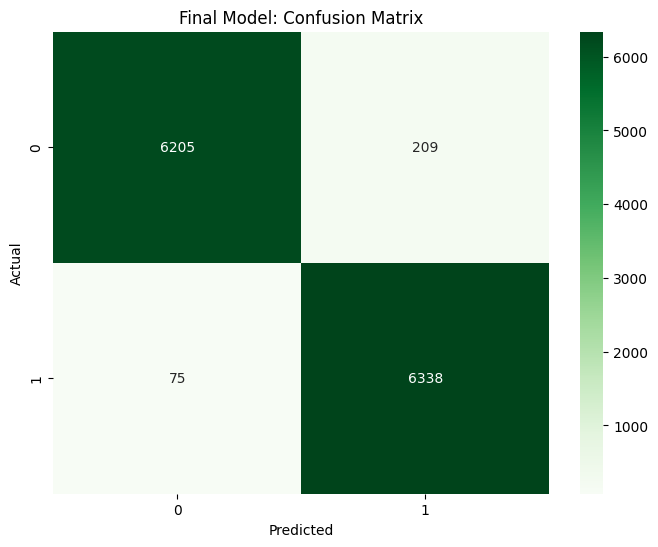

In [15]:
# 7. Visualization: Confusion Matrix
# ---------------------------------------------------------
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Final Model: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\Arsalan Khatri\AppData\Local\Temp\ipykernel_3248\3479778296.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='magma')


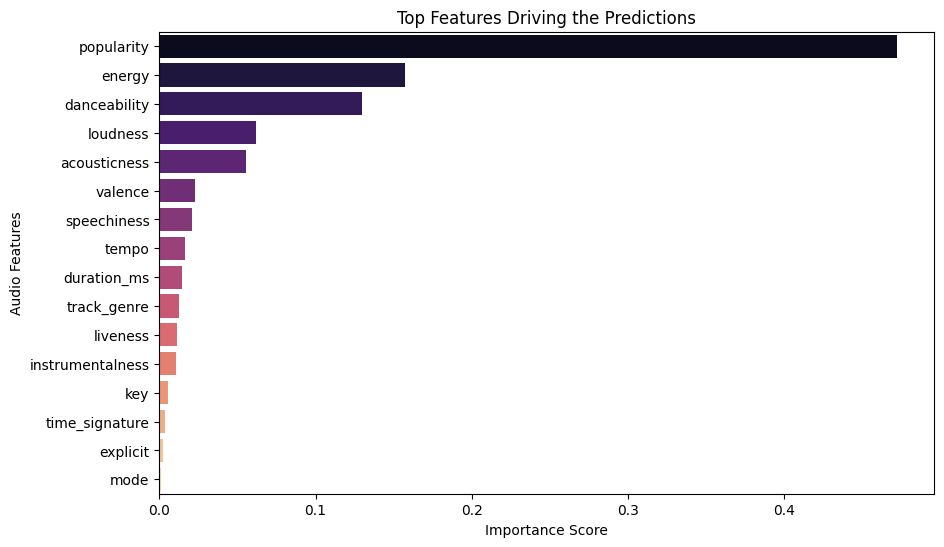

In [16]:
# 8. Visualization: Feature Importance
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='magma')
plt.title('Top Features Driving the Predictions')
plt.xlabel('Importance Score')
plt.ylabel('Audio Features')
plt.show()

# 7) Test Machine Learning Model

In [17]:
def predict_new_song(features_list):
    # Converting features into a DataFrame
    input_df = pd.DataFrame([features_list], columns=X.columns)
    
    # Scaling the data (using the same scaler that was used during training)
    scaled_input = scaler.transform(input_df)
    
    # Obtaining the prediction
    res = model.predict(scaled_input)[0]
    
    # Calculating the confidence (probability)
    conf = model.predict_proba(scaled_input)[0][res]
    
    prediction_text = "Repeat (1)" if res == 1 else "No Repeat (0)"
    return prediction_text, f"{conf*100:.2f}%"

In [18]:
multiple_songs_data= [    
    [95, 190000, 0, 0.88, 0.92, 1, -3.5, 1, 0.08, 0.02, 0.0, 0.25, 0.95, 128, 4, 10],
    [40, 350000, 0, 0.35, 0.25, 5, -14.0, 0, 0.04, 0.85, 0.05, 0.12, 0.3, 85, 4, 102], 
    [85, 150000, 1, 0.82, 0.88, 11, -5.0, 1, 0.25, 0.1, 0.0, 0.35, 0.6, 145, 4, 50], 
    [15, 600000, 0, 0.2, 0.15, 2, -22.0, 1, 0.03, 0.95, 0.92, 0.1, 0.1, 70, 3, 15], 
    [70, 210000, 0, 0.65, 0.55, 0, -8.5, 1, 0.04, 0.45, 0.0, 0.1, 0.5, 110, 4, 88], 
    [50, 240000, 0, 0.72, 0.78, 9, -6.5, 0, 0.05, 0.15, 0.65, 0.18, 0.4, 130, 4, 25],
    [50, 240000, 0, 0.72, 0.78, 9, -6.5, 0, 0.05, 0.15, 0.65, 0.18, 0.4, 130, 14, 5],
    [10, 240000, 0, 0.72, 0.78, 9, 6.5, 0, 0.05, 0.15, 0.65, 0.18, 0.4, 130, 4, 25]
]

In [19]:
# 2. Prediction Loop
print(f"{'Song #':<10} | {'Prediction':<15} | {'Confidence':<12}")
print("-" * 45)

for i, song_features in enumerate(multiple_songs_data):
    res_text, conf_val = predict_new_song(song_features)
    print(f"Song {i+1:<5} | {res_text:<15} | {conf_val:<12}")

Song #     | Prediction      | Confidence  
---------------------------------------------
Song 1     | Repeat (1)      | 99.96%      
Song 2     | No Repeat (0)   | 100.00%     
Song 3     | Repeat (1)      | 99.74%      
Song 4     | No Repeat (0)   | 100.00%     
Song 5     | Repeat (1)      | 96.62%      
Song 6     | Repeat (1)      | 98.39%      
Song 7     | Repeat (1)      | 97.59%      
Song 8     | No Repeat (0)   | 87.77%      


# Project: Music Recommendation & Prediction

In this notebook, we build an ML pipeline to classify songs as "High Likelihood to Repeat" or "Low Likelihood." We process the raw data, engineering a target variable derived from song popularity and energy metrics. To ensure fair training, the dataset is balanced before feeding it into a **Random Forest Classifier**. The final model yields ~98% accuracy, and we conclude by identifying the top audio features driving these predictions and testing on custom inputs.